In [3]:
import xarray as xr
import numpy as np
import sys
import os
# go one level up (from test/ to project/)
sys.path.append(os.path.abspath('..'))
import wildfire_analysis.cffdrs as cffdrs
from wildfire_analysis.cffdrs import cffdrs_calc


# Open your NetCDF files
ds1 = xr.open_dataset('w_n.nc')
ds2 = xr.open_dataset('tp_n.nc')

# Extract variables and convert units as needed
t2m_c = ds1['t2m'] - 273.15  # K to C
d2m_c = ds1['d2m'] - 273.15

# Convert units
t2m_c = ds1['t2m'] - 273.15
d2m_c = ds1['d2m'] - 273.15
wind_kmh = np.sqrt(ds1['u10']**2 + ds1['v10']**2) * 3.6  # m/s to km/h
precip_mm = ds2['tp'] * 1000  # m to mm

# Compute relative humidity function
def calc_rh(t, d):
    Es = 6.11 * 10.0 ** (7.5 * t / (237.7 + t))
    E = 6.11 * 10.0 ** (7.5 * d / (237.7 + d))
    return (E / Es) * 100.0

rh = calc_rh(t2m_c, d2m_c)

# Prepare month array (1-12 per timestep)
# If your time coordinate is datetime64, you can use:
months = ds1['valid_time'].dt.month.values

In [4]:
# Import your cffdrs functions here

result = cffdrs_calc(
    tas=t2m_c.values,        # in °C
    pr=precip_mm.values,     # in mm/day
    sfcWind=wind_kmh.values, # in km/h
    hurs=rh.values,          # in %
    mon=months               # 1-12 array
)


In [6]:
import pandas as pd
import numpy as np

# Extract time, latitude, longitude arrays from your dataset
dates = ds1['valid_time'].values    # shape: (nt,)
lats = ds1['latitude'].values # or ds1['lat'].values, check your data!
lons = ds1['longitude'].values # or ds1['lon'].values, check your data!

nt, nlat, nlon = result['fwi'].shape

# Build all combinations (time, lat, lon)
times = np.repeat(dates, nlat*nlon)
lat_grid = np.tile(np.repeat(lats, nlon), nt)
lon_grid = np.tile(np.tile(lons, nlat), nt)

# Flatten each result array
def flatten(arr):
    return arr.reshape(-1)

df = pd.DataFrame({
    'time': times,
    'lat': lat_grid,
    'lon': lon_grid,
    'FFMC': flatten(result['ffmc']),
    'DMC': flatten(result['dmc']),
    'DC': flatten(result['dc']),
    'ISI': flatten(result['isi']),
    'BUI': flatten(result['bui']),
    'FWI': flatten(result['fwi']),
    'DSR': flatten(result['dsr']),
})

df.to_csv('cffdrs_spatial_timeseries.csv', index=False)


In [7]:
import xarray as xr
import numpy as np

# Compose a dataset from your result dict and coordinate arrays
# Ensure that dates, lats, lons are all 1D arrays of shapes (nt,), (nlat,), (nlon,)
ds_out = xr.Dataset(
    {
        'FFMC': (('time', 'lat', 'lon'), result['ffmc']),
        'DMC': (('time', 'lat', 'lon'), result['dmc']),
        'DC': (('time', 'lat', 'lon'), result['dc']),
        'ISI': (('time', 'lat', 'lon'), result['isi']),
        'BUI': (('time', 'lat', 'lon'), result['bui']),
        'FWI': (('time', 'lat', 'lon'), result['fwi']),
        'DSR': (('time', 'lat', 'lon'), result['dsr']),
    },
    coords={
        'time': dates,
        'lat': lats,
        'lon': lons,
    }
)

# Save dataset to NetCDF file
ds_out.to_netcdf('cffdrs_outputs.nc')


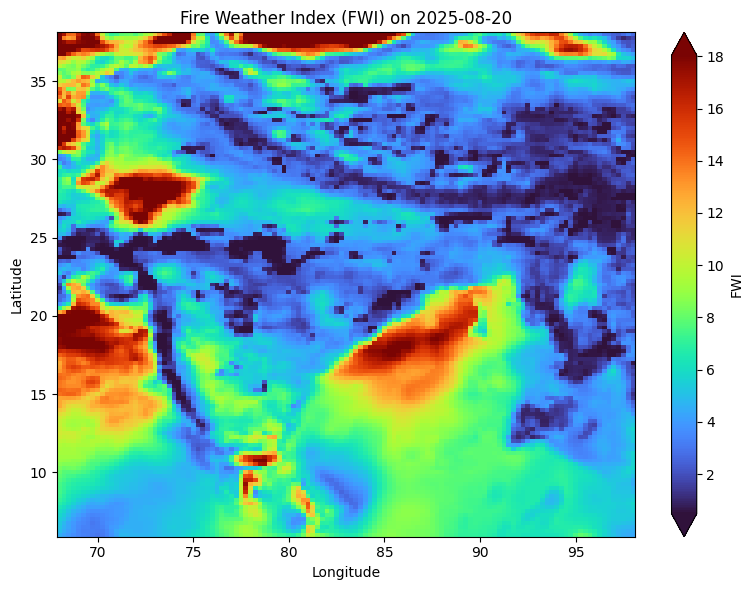

In [8]:
import matplotlib.pyplot as plt

# Load the saved NetCDF file
ds = xr.open_dataset('cffdrs_outputs.nc')

# Choose the variable and time index to plot (e.g., day 0)
fwi_oneday = ds['FWI'].isel(time=0)  # isel(time=n) for other time steps

plt.figure(figsize=(8, 6))
fwi_oneday.plot(cmap="turbo", robust=True)
plt.title(f"Fire Weather Index (FWI) on {str(ds.time.values[0])[:10]}")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()
